# Hessian Analysis
In this notebook we explore the hessian metrics with quantized models.

In [47]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys


# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from hessian import Hessian

### Utility methods

In [48]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

# RN08 (TinyResNet)

## Result

In [49]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [50]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/RN08'

RN08_layers = [
            'model.conv1', 
            'model.QBlocks.0.conv1', 
            'model.QBlocks.0.conv2', 
            'model.QBlocks.1.conv1', 
            'model.QBlocks.1.conv2',  
            'model.QBlocks.2.conv1', 
            'model.QBlocks.2.conv2',
            'model.QBlocks.2.shortcut',
            'model.QBlocks.3.conv1', 
            'model.QBlocks.3.conv2', 
            'model.QBlocks.4.conv1', 
            'model.QBlocks.4.conv2',
            'model.QBlocks.4.shortcut',
            'model.QBlocks.5.conv1', 
            'model.QBlocks.5.conv2', 
            'model.linear'
        ]

In [51]:
_, _, dataloader = rn08.get_cifar10_loaders(DATASET_DIR, 256)

Files already downloaded and verified


File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/net_1_best.pkl)
File hessian.pkl not found!
File not found

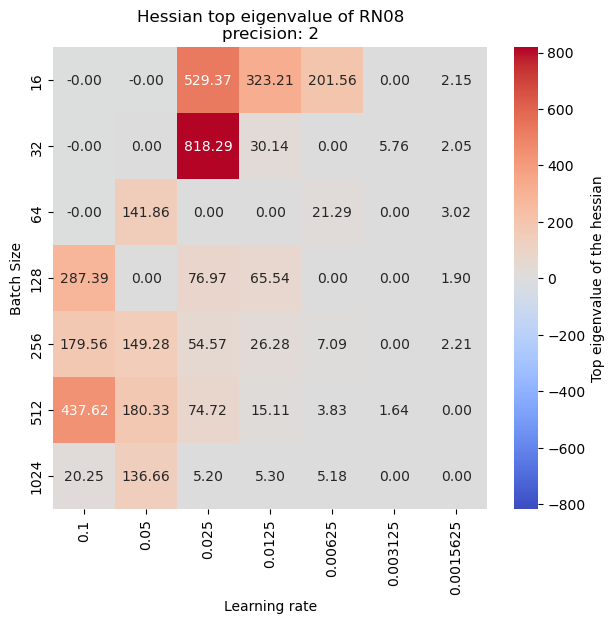

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!


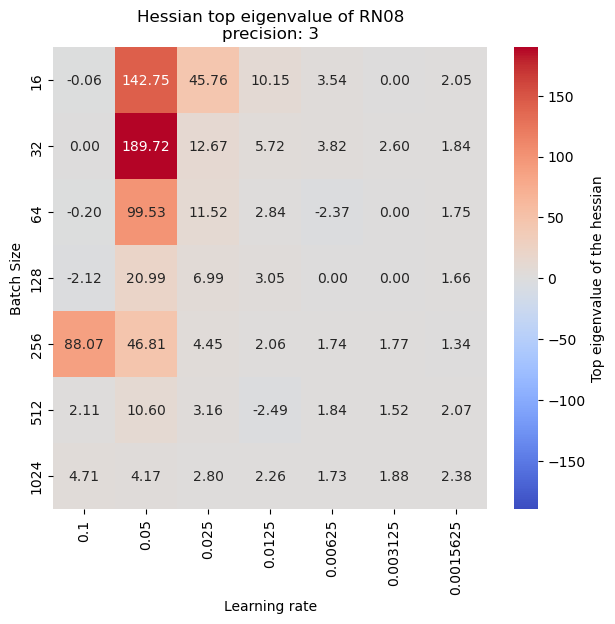

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/net_1_best.pkl)
File hessian.pkl not found!


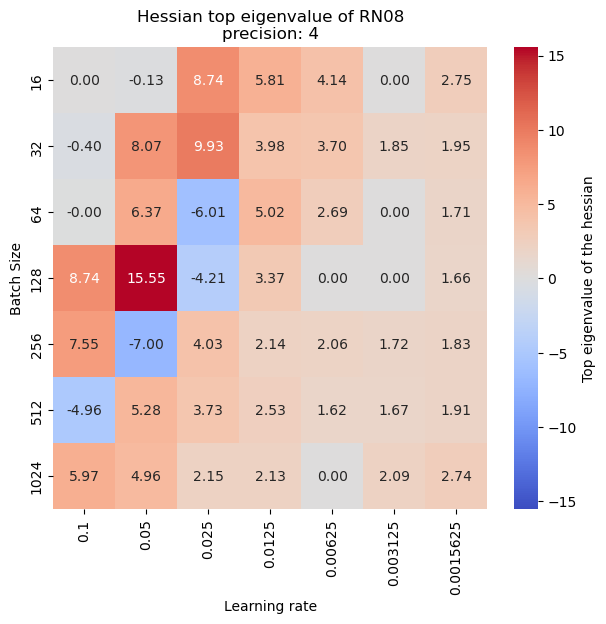

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!


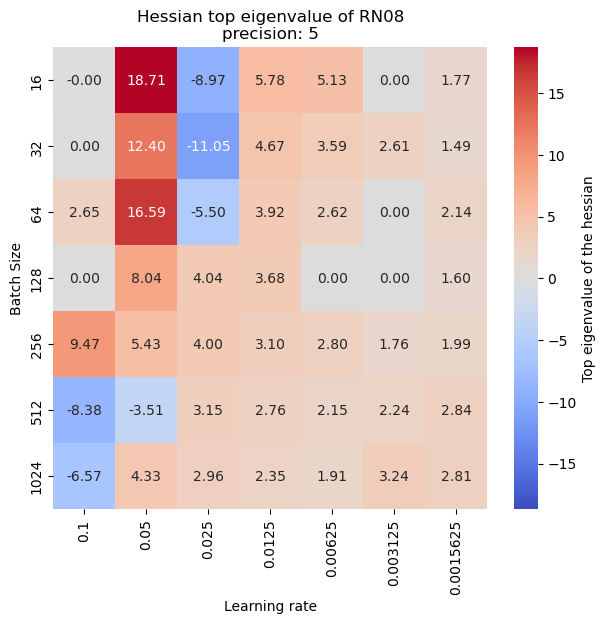

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/net_1_best.pkl)
File hessian.pkl not found!


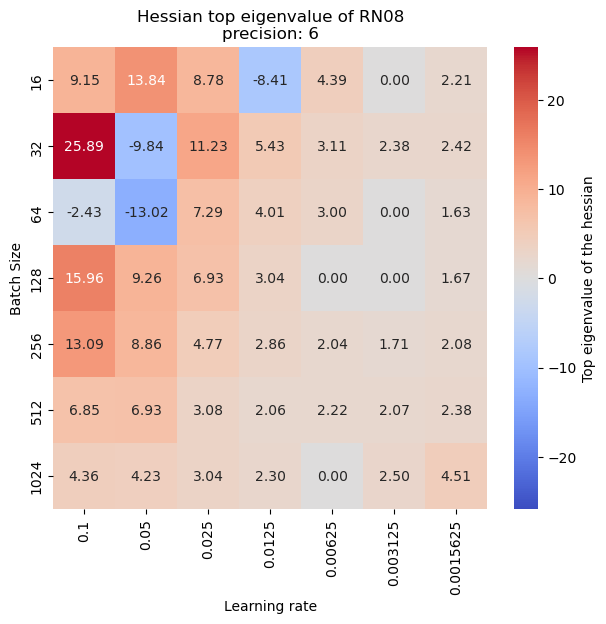

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/net_1_best.pkl)
File hessian.pkl not found!


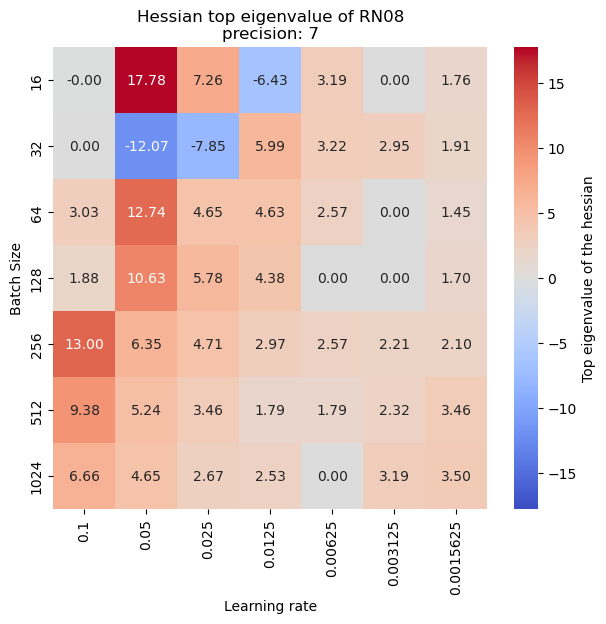

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!


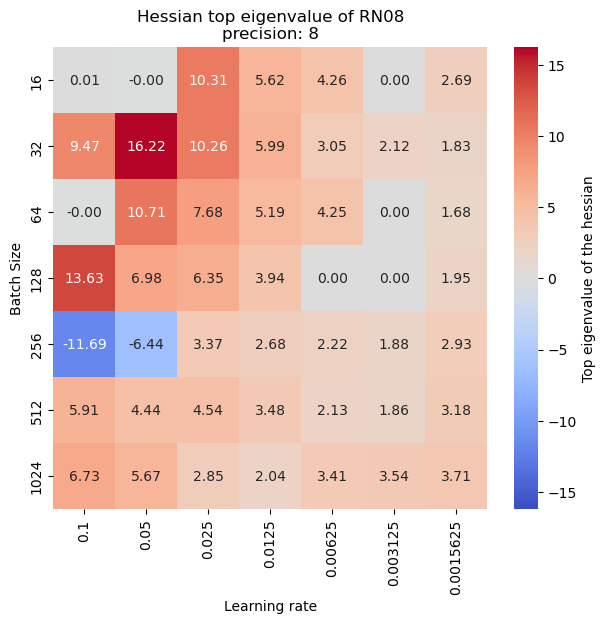

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!


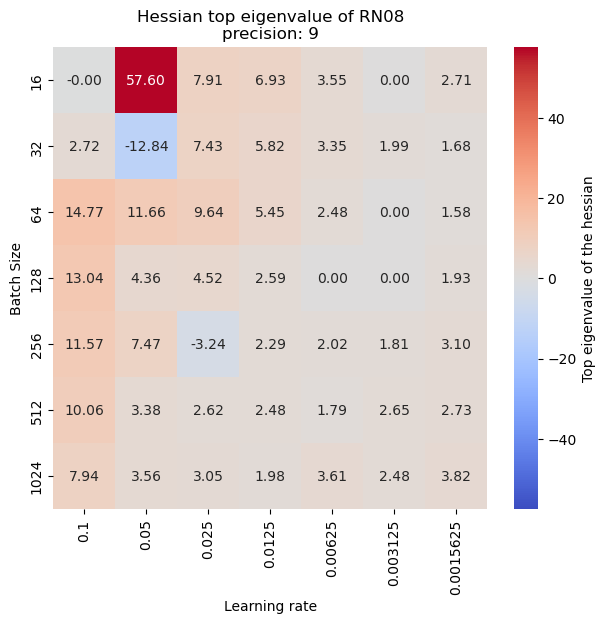

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!


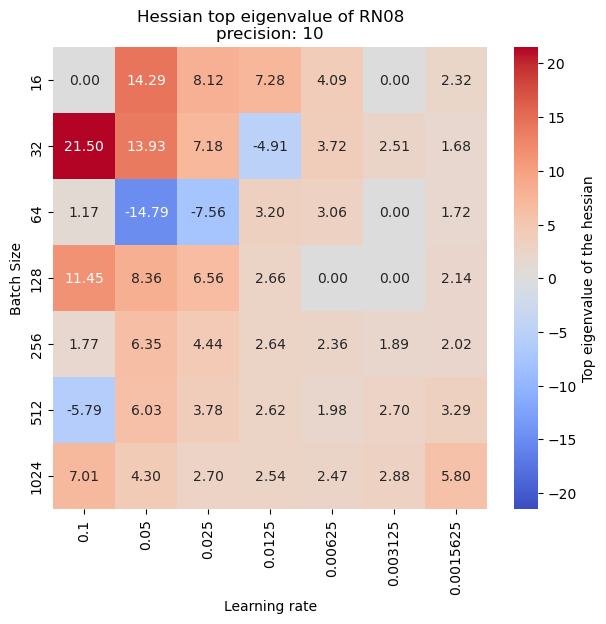

File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File hessian.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/net_1_best.pkl)
File hessian.pkl not found!


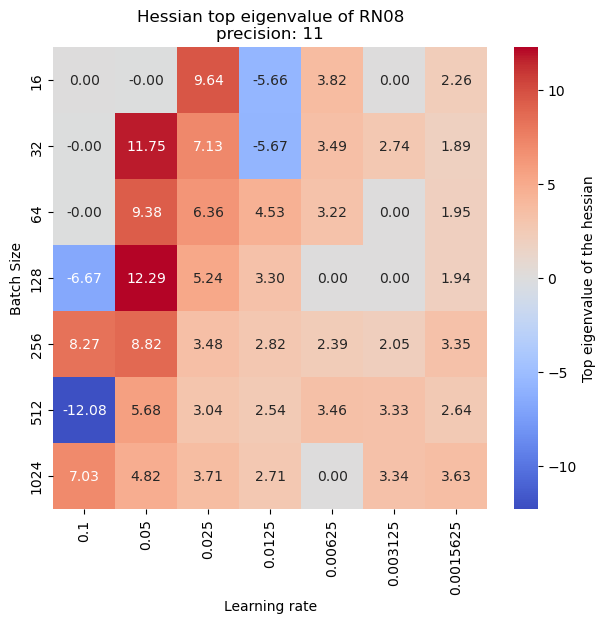

In [53]:
hessian_distribution = []
for p in precisions:
    trace_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    eigen_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            model, acc = rn08.get_model_and_accuracy(DATA_PATH, bs, lr, p)
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            hessian = Hessian(model, dataloader)
            
            trace = 0
            eigen_value = 0
            
            if hessian.load_from_file(path):
                trace = sum(hessian.results['trace'])
                eigen_value = hessian.results['eigenvalues'][0]
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
            
            hessian_distribution.append({
                'precision': p, 
                'trace': trace,
                'eigenvalue': eigen_value,
                'accuracy': acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    trace_matrix = pd.DataFrame(trace_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    eigen_matrix = pd.DataFrame(eigen_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    # plot_2d_heatmap(trace_matrix, 
    #                 f'Hessian Trace of RN08\nprecision: {p}', 
    #                 (0, np.log(trace_matrix.max().max())),
    #                 'Learning rate',
    #                 'Batch Size',
    #                 'Trace of the hessian',
    #                 cmap='rocket')
    
    
    plot_2d_heatmap(np.cbrt(eigen_matrix), 
                    f'Hessian top eigenvalue of RN08\nprecision: {p}', 
                    (-np.cbrt(eigen_matrix.max().max()), np.cbrt(eigen_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Top eigenvalue of the hessian',
                    cmap='coolwarm')


In [ ]:
hessian_distribution_df = pd.DataFrame(hessian_distribution)
hessian_distribution_df.to_csv("./results/rn08/hessian.csv")